In [1]:
import tensorflow as tf
# 預設情況下，tensorflow會為了避免碎片化的記憶體造成效能不佳的情況而一次性的佔用顯卡所有記憶體，
# 這部份可以透過tf.config來限制硬體資源以及指定顯卡記憶體的使用。
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                # If memory growth is enabled for a PhysicalDevice, 
                # the runtime initialization will not allocate all memory on the device. 
                # Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
                tf.config.experimental.set_memory_growth(gpu, True)
            # 指定使用哪顆GPU
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

In [2]:
select_gpu(0) 
epochs = 5
model_name = 'bilstm-nltk-token'
sequence_length = 48

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [3]:
import pandas as pd
import numpy as np
import json

In [4]:
data_path = '/home/Danny/Data-Mining/lab2/kaggle/data/'

In [5]:
json_list = list()
with open(data_path + 'tweets_DM.json' , 'r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [6]:
tweet_list = list()
for json in json_list:
    tweet_id = json['_source']['tweet']['tweet_id']
    hashtags = json['_source']['tweet']['hashtags']
    hashtag = ' '.join(hashtags)
    text = json['_source']['tweet']['text']
#     text = text + ' ' + hashtag
    tweet_list.append([tweet_id, text])

In [7]:
emotion_df = pd.read_csv(data_path + 'emotion.csv')
emotion_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [8]:
identification_df = pd.read_csv(data_path + 'data_identification.csv')
identification_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [9]:
emoji_dict = {
    "😂": "lolface",
    "😇": "smile",
    "😀": "smile",
    "🎉": "party",
    "😳": "embarrassed",
    "😔": "sadface",
    "👀": "shifty",
    "🤷": "shrugging",
    "💔": "brokenhearted",
    "👻": "ghost",
    "😍": "heart",
    "🙄": "disdain",
    "💖": "heart",
    "✌": "victory",
    "🎶": "music",
    "😱": "shock",
    "😃": "smile",
    "😒": "unsatisfied",
    "👊": "brofist",
    "😄": "smile",
    "🌞": "smile",
    "🙌": "celebration",
    "😁": "smile",
    "🤗": "hugging",
    "🤣": "rofl",
    "🌈": "gaypride",
    "😉": "winking",
    "💞": "heart",
    "🙃": "irony",
    "😜": "winking",
    "😭": "bawling",
    "🤔": "thinker",
    "😎": "cool",
    "💛": "heart",
    "💚": "heart",
    "💃": "fun",
    "💗": "heart",
    "😬": "awkward",
    "😌": "relieved",
    "😅": "whew",
    "💋": "kiss",
    "🙈": "laugh",
    "😊": "^^",
    "👌": "okay",
    "😡": "angry",
    "😘": "kiss",
    "😩": "weary",
    "🔥": "excellent",
    "💙": "heart",
    "💕": "heart",
    "👏": "clapping",
    "👍": "thumbsup",
    "💯": "perfect",
    "💜": "heart",
    "🕘" : "late",
    "😡" : "angry",
    "😒" : "dissatisfied",
    "😤" : "angry",
    "😠" : "angry",
    "😑" : "annoy",
    "😰": "anxious",
    "😯": "surprise",
    "😨": "scared",
    "😲": "astonished",
    "💪": "strong",
    "🤦": "facepalm",
    "✨": "sparkle",
    "😢": "crying",
    "💓": "heart",
    "👑": "crown",
    "🤘": "rockon",
    "🌹": "rose",
    "😋": "delicious",
    "😏": "flirting",
    "😆": "XD",
    "😫": "exhausted",
    "😦": "frowning",
    "🙏": "please",
}

In [10]:
frequent_name_dict = {
    "#realdonaldtrump": "sadness",
    "#fifthharmony": "sadness",
    "#mostrequestlive": "sadness",
    "#onairromeo": "sadness",
    "#matthardybrand": "sadness",
}

In [11]:
text_df = pd.DataFrame(tweet_list, columns=['tweet_id', 'text'])
text_df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [12]:
import re
def replace_word(text):
    text_list = text.split()
    for i, j in enumerate(text_list):
        if j in emoji_dict:
            text_list[i] = emoji_dict[j]
        if j in frequent_name_dict:
            text_list[i] = frequent_name_dict[j]
    text = ' '.join(text_list)
    text = re.sub('<lh>|<|>|@|#|', '', text)
    return text.split()

In [13]:
%%time
import nltk
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
text_df['token'] = text_df['text'].apply(lambda s : s.lower())
text_df['token'] = text_df['token'].apply(lambda s : tweet_tokenizer.tokenize(s))
text_df['token'] = text_df['token'].apply(lambda s : ' '.join(s))
text_df['token'] = text_df['token'].apply(lambda s : replace_word(s))
text_df

CPU times: user 3min 33s, sys: 36.7 s, total: 4min 10s
Wall time: 4min 11s


,tweet_id,text,token
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...","[people, who, post, "", add, me, on, snapchat, ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[as, we, see, ,, trump, is, dangerous, to, fre..."
2,0x28b412,"Confident of your obedience, I write to you, k...","[confident, of, your, obedience, ,, i, write, ..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,"[now, issa, is, stalking, tasha, lolface, lolf..."
4,0x2de201,"""Trust is not the same as faith. A friend is s...","["", trust, is, not, the, same, as, faith, ., a..."
...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,"[when, you, buy, the, last, 2, tickets, remain..."
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,"[i, swear, all, this, hard, work, gone, pay, o..."
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,"[no, card, left, when, i, wasn't, in, so, i, h..."
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...","[ah, ,, corporate, life, ,, where, you, can, d..."


In [14]:
# %%time
# from kashgari.tokenizers import BertTokenizer
# vocab_path = '/home/Danny/pretrain_model/{}/vocab.txt'.format(model_name)
# tokenizer = BertTokenizer.load_from_vocab_file(vocab_path)
# text_df['token'] = text_df['text'].apply(lambda s : tokenizer.tokenize(s))
# text_df

In [15]:
# text_df['token'] = text_df['text'].apply(lambda s : s.split())
# text_df

In [16]:
test_df = identification_df[identification_df['identification'] == 'test']
# test_df

In [17]:
train_df = text_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id')
# train_df

In [18]:
x_list = train_df['token'].to_list()
y_list = train_df['emotion'].to_list()
print(len(x_list))
print(len(y_list))

1455563
1455563


In [19]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_list, y_list, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))
print(len(valid_x), len(valid_y))

931560 931560
291113 291113
232890 232890


In [22]:
%%time
import kashgari
from kashgari.tasks.classification import BiLSTM_Model
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')
from kashgari.embeddings import BertEmbedding
# bert_embed = BertEmbedding('/home/Danny/pretrain_model/{}'.format(model_name))
model = BiLSTM_Model()
history = model.fit(train_x, 
                    train_y, 
                    valid_x, 
                    valid_y,
                    epochs=epochs,
                    batch_size=256,
                   )

Preparing text vocab dict: 100%|██████████| 232890/232890 [00:01<00:00, 120429.63it/s]
2020-12-04 14:34:08,703 [DEBUG] kashgari - --- Build vocab dict finished, Total: 97676 ---
2020-12-04 14:34:08,707 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '.', 'the', '!', 'to', ',', 'i']
Calculating sequence length: 100%|██████████| 232890/232890 [00:00<00:00, 1174375.47it/s]
2020-12-04 14:34:11,170 [DEBUG] kashgari - Calculated sequence length = 28
2020-12-04 14:34:13,154 [DEBUG] kashgari - Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         9767600   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
______________

Epoch 1/5
3638/3638 [==============================] - 382s 105ms/step - loss: 1.2729 - accuracy: 0.5410 - val_loss: 1.1962 - val_accuracy: 0.5688
Epoch 2/5
3638/3638 [==============================] - 380s 105ms/step - loss: 1.0997 - accuracy: 0.6041 - val_loss: 1.1974 - val_accuracy: 0.5746
Epoch 3/5
3638/3638 [==============================] - 383s 105ms/step - loss: 0.9709 - accuracy: 0.6516 - val_loss: 1.3064 - val_accuracy: 0.5639
Epoch 4/5
3638/3638 [==============================] - 391s 108ms/step - loss: 0.8299 - accuracy: 0.7033 - val_loss: 1.5088 - val_accuracy: 0.5500
Epoch 5/5
3638/3638 [==============================] - 391s 108ms/step - loss: 0.7091 - accuracy: 0.7477 - val_loss: 1.7503 - val_accuracy: 0.5400
CPU times: user 3h 6min 37s, sys: 30min 15s, total: 3h 36min 53s
Wall time: 32min 31s


In [23]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
model.save(model_path)

2020-12-04 15:06:29,480 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 101
2020-12-04 15:06:33,616 [DEBUG] kashgari - predict input shape (291113, 101) x: 
[[   2  108   11 ...    0    0    0]
 [   2  165   81 ...    0    0    0]
 [   2  752   58 ...    0    0    0]
 ...
 [   2    9 1429 ...    0    0    0]
 [   2   12  329 ...    0    0    0]
 [   2  891 4487 ...    0    0    0]]
2020-12-04 15:07:26,614 [DEBUG] kashgari - predict output shape (291113, 8)
2020-12-04 15:07:26,855 [DEBUG] kashgari - predict output argmax: [2 0 1 ... 3 0 5]


              precision    recall  f1-score   support

       anger     0.3757    0.3097    0.3395      7946
anticipation     0.6438    0.5267    0.5794     49984
     disgust     0.4460    0.3508    0.3927     27669
        fear     0.4788    0.4456    0.4616     12846
         joy     0.5891    0.7436    0.6574    102943
     sadness     0.4493    0.4991    0.4729     38745
    surprise     0.3719    0.2740    0.3156      9816
       trust     0.5087    0.3672    0.4266     41164

    accuracy                         0.5425    291113
   macro avg     0.4829    0.4396    0.4557    291113
weighted avg     0.5369    0.5425    0.5328    291113



2020-12-04 15:07:34,774 [INFO] kashgari - model saved to /home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bilstm-nltk-token_epoch_5


'/home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bilstm-nltk-token_epoch_5'

DEBUG:matplotlib:CONFIGDIR=/home/Danny/.config/matplotlib
DEBUG:matplotlib:(private) matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.2.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconf

DEBUG:matplotlib:CACHEDIR=/home/Danny/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/Danny/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gubbi' (Gubbi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-L.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fin

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sco

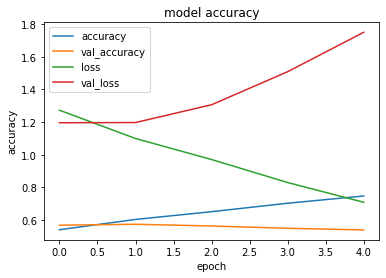

In [24]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [25]:
# model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
# model = kashgari.utils.load_model(model_path)
# model.evaluate(test_x, test_y)

In [26]:
test_df = test_df.merge(text_df, left_on='tweet_id', right_on='tweet_id')
test_df

,tweet_id,identification,text,token
0,0x28cc61,test,@Habbo I've seen two separate colours of the e...,"[i've, seen, two, separate, colours, of, the, ..."
1,0x2db41f,test,@FoxNews @KellyannePolls No serious self respe...,"[no, serious, self, respecting, individual, be..."
2,0x2466f6,test,"Looking for a new car, and it says 1 lady owne...","[looking, for, a, new, car, ,, and, it, says, ..."
3,0x23f9e9,test,@cineworld “only the brave” just out and fount...,"[“, only, the, brave, ”, just, out, and, fount..."
4,0x1fb4e1,test,Felt like total dog 💩 going into open gym and ...,"[felt, like, total, dog, 💩, going, into, open,..."
...,...,...,...,...
411967,0x2c4dc2,test,6 year old walks in astounded. Mum! Look how b...,"[6, year, old, walks, in, astounded, ., mum, !..."
411968,0x31be7c,test,Only one week to go until the #inspiringvolunt...,"[only, one, week, to, go, until, the, inspirin..."
411969,0x1ca58e,test,"I just got caught up with the manga for ""My He...","[i, just, got, caught, up, with, the, manga, f..."
411970,0x35c8ba,test,Speak only when spoken to and make hot ass mus...,"[speak, only, when, spoken, to, and, make, hot..."


In [27]:
text_list = test_df['token'].tolist()
# text_list

In [28]:
predict_list = model.predict(text_list)
# predict_list

2020-12-04 15:07:52,537 [DEBUG] kashgari - predict input shape (411972, 96) x: 
[[   2  235  455 ...    0    0    0]
 [   2   61 1406 ...    0    0    0]
 [   2  281   13 ...    0    0    0]
 ...
 [   2    9   37 ...    0    0    0]
 [   2  735   80 ...    0    0    0]
 [   2   88   44 ...    0    0    0]]
2020-12-04 15:09:09,042 [DEBUG] kashgari - predict output shape (411972, 8)
2020-12-04 15:09:09,372 [DEBUG] kashgari - predict output argmax: [1 4 0 ... 3 0 0]


In [29]:
test_df['predict'] = predict_list
# test_df

In [30]:
output_df = test_df[['tweet_id', 'predict']]
output_df = output_df.rename(columns={'tweet_id':'id', 'predict':'emotion'})
# output_df

In [31]:
output_path = 'output/{}_epoch_{}.csv'.format(model_name, epochs)
output_df.to_csv(output_path, index=False, header=True)